In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import blimpy as bl 
import setigen as stg 
from astropy import units as u
from astropy.coordinates import Angle

%matplotlib inline

In [52]:
fb = bl.Waterfall('/datax/scratch/benjb/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5')
fb.info()
print(fb.header)


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :                8421.38671875 MHz
            foff :      -2.7939677238464355e-06 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                          1048576
            nifs :                                1
     source_name :                        VOYAGER-1
         src_dej :                     12:24:13.614
         src_raj :                     17:12:40.481
    telescope_id :                                6
           tsamp :               18.253611007999982
   tstart (ISOT) :          2020-07-16T22:13:56.000
    tstart (MJD) :                59046.92634259259
        za_start :                              0.0

Num ints in file :                               16
      File shape :                 (16, 1, 

In [2]:
fch1 = 6095.214842353016
foff = 2.7939677238464355
n_inj = 2000
fillspace = 10000 # Hz
nchans = (2*fillspace//foff)*n_inj
print(foff*n_inj*fillspace*2/1e6, f'MHz total for {n_inj} injections')
print(nchans)

111.75870895385742 MHz total for 2000 injections
14316000.0


In [128]:
synth_header_dict = {'DIMENSION_LABELS': np.array([b'time', b'feed_id', b'frequency'], dtype=object), 
                     'az_start': 0.0, 
                     'data_type': 1, 
                     'fch1': 10000, 
                     'foff': 2.7939677238464355e-06, 
                     'machine_id': 20, 
                     'nbits': 32, 
                     'nchans': (2*fillspace//foff)*n_inj, 
                     'nifs': 1, 
                     'source_name': 'synthetic', 
                     'src_dej': Angle(0*u.rad), 
                     'src_raj': Angle(0*u.rad), 
                     'telescope_id': 6, 
                     'tsamp': 18.253611007999982, 
                     'tstart': 59046.92634259259, 
                     'za_start': 0.0}

In [ ]:
# make small frame of 20 kHz that contains each signal
# concatenate data from all the small frames together
# gives "scan" a couple times larger than a usual scan; easy to handle with turboSETI or BLISS

In [15]:
frame_list = []

# drifts = np.random.uniform(-4, 4, n_inj)
drifts = np.zeros(n_inj) + 0.1 # less than unit drift rate of 0.153
# snrs = np.random.uniform(10, 1000, n_inj)
snrs = np.zeros(n_inj) + 1000
# widths = np.random.randint(1, 4, n_inj)

import time

start = time.time()

for i in range(n_inj):
    frame = stg.Frame(fchans=2*fillspace//foff*u.pixel,
                    tchans=16*u.pixel,
                    df=foff*u.Hz,
                    dt=18.253611008*u.s,
                    fch1=fch1*u.MHz)
    noise = frame.add_noise(x_mean=10**10, noise_type='chi2') # chi2: assume squared bc power values are all positive and real
    if i%2 == 0:
        signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=int(fillspace//foff)),
                                                    drift_rate=drifts[i]*u.Hz/u.s),
                                stg.constant_t_profile(level=frame.get_intensity(snr=snrs[i])),
                                stg.gaussian_f_profile(width=1*foff*u.Hz),
                                stg.constant_bp_profile(level=2),
                                doppler_smearing=True,
                                smearing_subsamples=10)

    frame_list.append(frame.data)
    print(f'Finished {i+1}: {(time.time() - start)/(i+1)} seconds for this round.')

data = np.concatenate(frame_list, axis=1)
print(np.shape(data))

fullframe = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.253611008*u.s,
                            fch1=10000*u.MHz,
                            ascending=True,
                            data=data.astype('<f4'))

fullframe.save_h5(filename=f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_{n_inj}_injections_2.0000.h5')

#expdata = np.expand_dims(data, axis=1)
#print(expdata.dtype)
#plt.imshow(data[:,50000-500:50000+500], aspect='auto', interpolation='None')
#plt.show()

#fb_new = bl.Waterfall(filename=None, header_dict=synth_header_dict, data_array=expdata)
#print(fb_new.data.dtype)
#fb_new.write_to_hdf5(f'/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_{n_inj}_injections.0000.h5')
freqs = np.arange(n_inj)*(2*fillspace)/1e6 + fillspace/1e6 + 10000
print(freqs)
np.save(f'/datax/scratch/benjb/bliss_voyager_test/injections/high_SNR_no_drift_injections/synthetic_data_{n_inj}_injection_parameters_2.npy', np.array([freqs, drifts, snrs]))

Finished 1: 0.09074759483337402 seconds for this round.
Finished 2: 0.05208325386047363 seconds for this round.
Finished 3: 0.06284046173095703 seconds for this round.
Finished 4: 0.05066192150115967 seconds for this round.
Finished 5: 0.054290056228637695 seconds for this round.
Finished 6: 0.04697267214457194 seconds for this round.
Finished 7: 0.05035914693559919 seconds for this round.
Finished 8: 0.04538336396217346 seconds for this round.
Finished 9: 0.04598686430189344 seconds for this round.
Finished 10: 0.04228029251098633 seconds for this round.
Finished 11: 0.04324074224992232 seconds for this round.
Finished 12: 0.04039778312047323 seconds for this round.
Finished 13: 0.0413504197047307 seconds for this round.
Finished 14: 0.03904422691890171 seconds for this round.
Finished 15: 0.03994921048482259 seconds for this round.
Finished 16: 0.03803883492946625 seconds for this round.
Finished 17: 0.03886127471923828 seconds for this round.
Finished 18: 0.03721258375379774 seconds

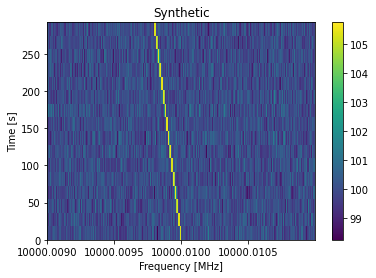

In [8]:
fb = bl.Waterfall('/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_2000_injections.0000.h5',
                  f_start=10000.01-0.001, f_stop=10000.01+0.001)
fb.plot_waterfall()

(16, 1, 71580)
3579.0


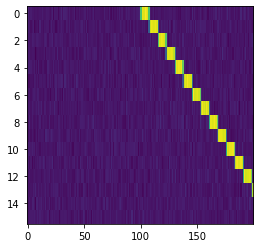

In [125]:
fb = bl.Waterfall('/datax/scratch/benjb/bliss_voyager_test/injections/synthetic_data_10_injections.0000.h5')
print(np.shape(fb.data))
print(10000//foff)
plt.imshow(np.squeeze(fb.data)[:,int(10000//foff)-100:int(10000//foff)+100], aspect=12, interpolation='None')
plt.show()

In [106]:
print(np.min(fb.data))
print(np.max(fb.data))

5776191000.0
15459760000.0


In [ ]:
n_inj = 5000

h5_path = '/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5'

#a, b, c, d = 1100, 1200, 1340, 1900
#center_frequencies = np.random.uniform(a-b, d-c, n_inj)
#center_frequencies += np.where(center_frequencies < 0, b, c)
center_frequencies = np.random.uniform(1100, 1900, n_inj)
drift_rates = np.random.uniform(-4, 4, n_inj)
snrs = np.random.uniform(1, 1000, n_inj)
#snrs = np.arange(1000) + 1
widths = np.random.randint(1, 4, n_inj)

wf = [bl.Waterfall(h5_path, f_start=center_frequencies[j]-0.007, f_stop=center_frequencies[j]+0.007) for j in range(n_inj)]

fb = bl.Waterfall(h5_path)
freqs, data = fb.grab_data()
header_dict = fb.header

for j in range(n_inj):
    c = stg.Frame(wf[j])
    block_freqs, _ = wf[j].grab_data()
    print(f'Adding signal {j} ...')
    c.add_signal(stg.constant_path(f_start=(center_frequencies[j])*u.MHz,
                               drift_rate=drift_rates[j]*u.Hz/u.s),
                           stg.constant_t_profile(level=c.get_intensity(snr=snrs[j])),
                           stg.sinc2_f_profile(width=widths[j]*c.df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True,
                           smearing_subsamples=15)
    data[:,np.where((freqs >= block_freqs[-1]) & (freqs <= block_freqs[0]))[0]] = np.flip(c.data, axis=1)

fb_new = bl.Waterfall(filename=None, header_dict=header_dict, data_array=np.expand_dims(data, axis=1))

fb_new.write_to_hdf5('/datax/scratch/benjb/C23_L_M81_injections/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5')
np.save('/datax/scratch/benjb/C23_L_M81_injections/injections_freq_DR_snr_widths_MESSIER081.npy', np.array([center_frequencies, drift_rates, snrs, widths]))


In [93]:
h5_path = '/datag/pipeline/AGBT20A_999_03/collate/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5'
fb = bl.Waterfall(h5_path, f_start=1420, f_stop=1420.5)
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2251.46484375 MHz
            foff :      -2.7939677238464355e-06 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                        536870912
            nifs :                                1
     source_name :                       MESSIER081
         src_dej :                       69:03:55.8
         src_raj :                      9:55:33.192
    telescope_id :                                6
           tsamp :               18.253611007999982
   tstart (ISOT) :          2020-02-06T17:40:46.000
    tstart (MJD) :                58885.73664351852
        za_start :                              0.0

Num ints in file :                               16
      File shape :               (16, 1, 53

In [94]:
fb.data.dtype

dtype('<f4')

In [107]:
df = pd.read_csv('/datax/scratch/benjb/bl_nearby_stars/star_cadences_catalog_with_receiver.csv')
df

,Target,Distance,Cadence ID,Frequency,.h5 path,Receiver
0,GJ1002,4.69,3635,1926,/datag/pipeline/AGBT16A_999_219/holding/splice...,Rcvr1_2
1,GJ1002,4.69,3635,1926,/datag/pipeline/AGBT16A_999_219/holding/splice...,Rcvr1_2
2,GJ1002,4.69,3635,1926,/datag/pipeline/AGBT16A_999_219/holding/splice...,Rcvr1_2
3,GJ1002,4.69,3635,1926,/datag/pipeline/AGBT16A_999_219/holding/splice...,Rcvr1_2
4,GJ1002,4.69,3635,1926,/datag/pipeline/AGBT16A_999_219/holding/splice...,Rcvr1_2
...,...,...,...,...,...,...
282853,SO0253,3.85,421558,7876,/datag/pipeline/AGBT23B_999_14/blc76_blp36/blc...,Rcvr8_10
282854,SO0253,3.85,421558,7876,/datag/pipeline/AGBT23B_999_14/blc76_blp36/blc...,Rcvr8_10
282855,SO0253,3.85,421558,7876,/datag/pipeline/AGBT23B_999_14/blc76_blp36/blc...,Rcvr8_10
282856,SO0253,3.85,421558,7876,/datag/pipeline/AGBT23B_999_14/blc76_blp36/blc...,Rcvr8_10
